<a href="https://colab.research.google.com/github/NicholasBaraghini/Ball-and-Beam-system-Optimal-Control/blob/main/OPTCON_Grp21_Ball_and_Beam_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTIMAL CONTROL EXAM PROJECT**

 Group 21:
   - Baraghini Nicholas 0000984041 
   - Curto Fabio
   - Iadarola Federico

In [1]:
# Libraries
import numpy as np
import matplotlib

import system_dynamic as sd
import optcon as opt
import cost_function
import matplotlib.pyplot as plt_
%matplotlib widget

import visualization as visu

**TRAJECTORY EXPLORATION** (Task 1)

In [2]:
# PARAMETERS SETTING

max_iterations = 9;
STOP_ITER = 1E-1; #Stop Iteration descent threshold

cc = 0.05
beta = 0.5

nx = 4; # nmumber of states
nu = 1; # number of inputs
tf = 5; # Seconds

params = {'dt':0.001,   # Step size - Forward Euler method
          'gg':9.81,    # gravitational acceleration [m/s^2]
          'mm':0.12,    # ball mass [kg]
          'rr':0.015,   # ball radius [m]
          'ii':11.6E-6, # ball inertia [kg*m^2]
          'II':0.1125,  # beam inertia [kg*m^2]
          'LL':1,        # beam lenght [m]
          'QQ':np.array([[0.1, 0, 0 , 0],
                        [ 0 ,0.1, 0 , 0],
                        [ 0 , 0,0.1, 0],
                        [ 0 , 0, 0 ,0.1]]),
          'RR':1,
          'QQ_T':np.array([[0.1, 0, 0 , 0],
                          [ 0 ,0.1, 0 , 0],
                          [ 0 , 0,0.1, 0],
                          [ 0 , 0, 0 ,0.1]])
              }

TT = int(tf/params['dt']); # rounding down of the time span divided in time in number oof time intervals

xx_init = np.zeros((nx,1)); # initial state


**Reference Definition** \
Step reference change between two equilibria 

In [3]:

# REFERENCE DEFINITION
ref_pos = 0.8; # ball reference position on the beam [m]
ref_inp = params['mm']*params['gg']*ref_pos; # input reference torque at reference pos ref_pos

# state reference definition:
xx_ref = np.zeros((nx,TT));
xx_ref[0,round(TT/2):TT] = ref_pos;

# input reference definition
uu_ref = np.zeros((nu,TT));
uu_ref[0,round(TT/2):TT] = ref_inp;
xx = np.zeros((nx,TT,max_iterations)); # state tensor uu = np.zeros((nu,TT,max_iterations)); # input tensor

cost = np.zeros((max_iterations,1)); # cost function values memory descent = np.zeros((max_iterations,1));

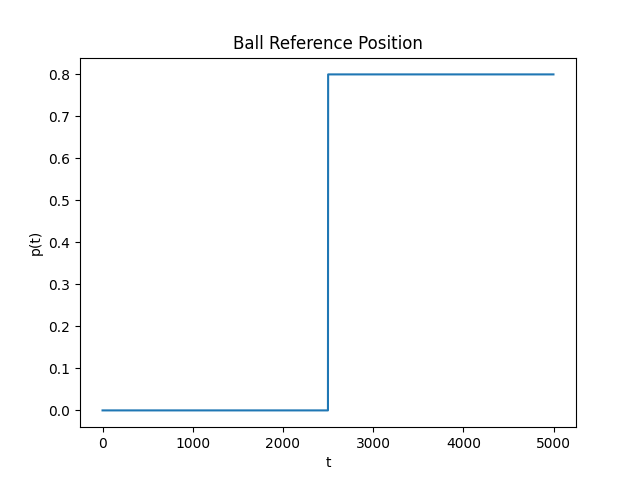

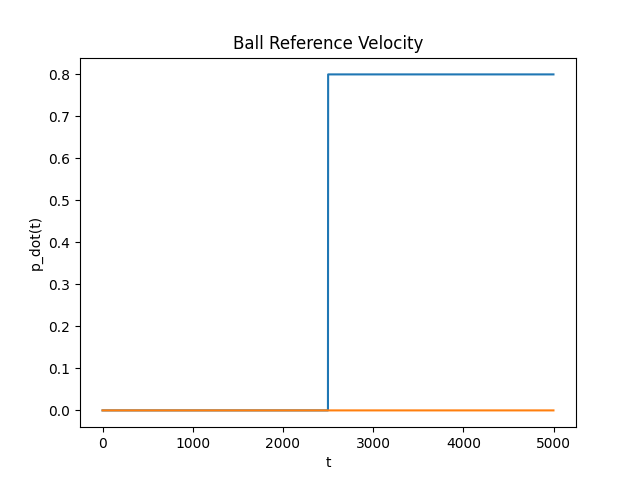

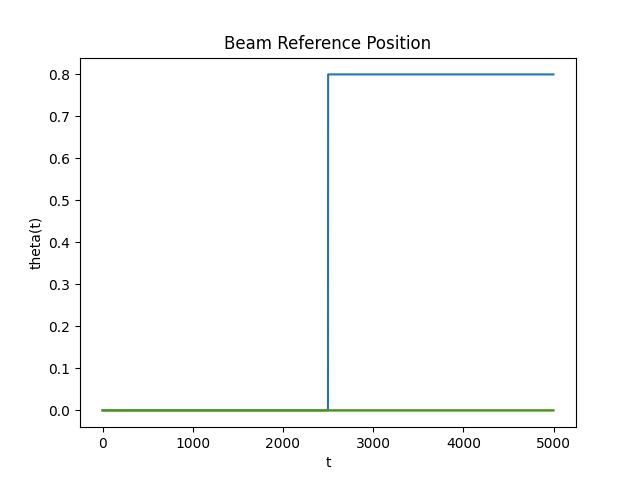

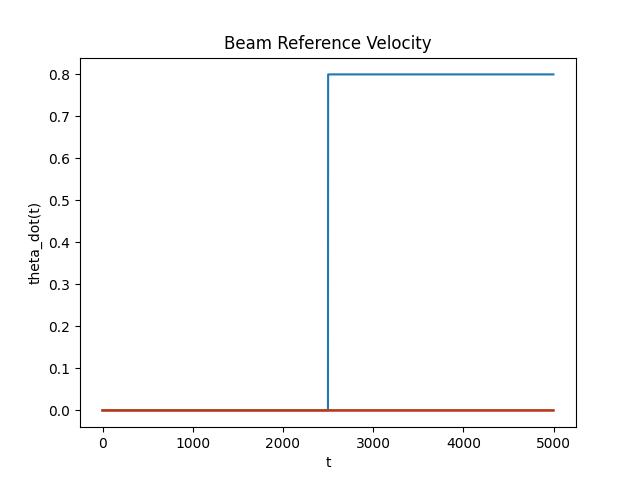

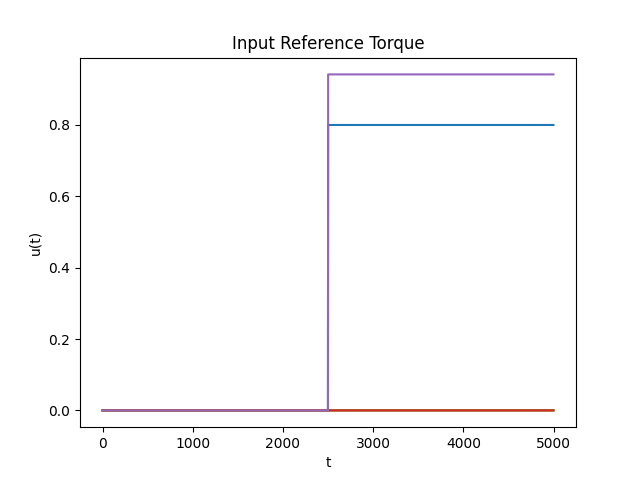

In [4]:
# Plotting the Graph
plt_.plot(range(0,TT),xx_ref[0, :])
plt_.title("Ball Reference Position")
plt_.xlabel("t")
plt_.ylabel("p(t)")
plt_.show()

# Plotting the Graph
plt_.plot(range(0,TT),xx_ref[1, :])
plt_.title("Ball Reference Velocity")
plt_.xlabel("t")
plt_.ylabel("p_dot(t)")
plt_.show()

# Plotting the Graph
plt_.plot(range(0,TT),xx_ref[2, :])
plt_.title("Beam Reference Position")
plt_.xlabel("t")
plt_.ylabel("theta(t)")
plt_.show()

# Plotting the Graph
plt_.plot(range(0,TT),xx_ref[3, :])
plt_.title("Beam Reference Velocity")
plt_.xlabel("t")
plt_.ylabel("theta_dot(t)")
plt_.show()

# Plotting the Graph
plt_.plot(range(0,TT),uu_ref[0, :])
plt_.title("Input Reference Torque")
plt_.xlabel("t")
plt_.ylabel("u(t)")
plt_.show()


**OPTIMIZATION LOOP**

In [5]:
## ITERATION LOOP

# Initializations
xx = np.zeros((nx,TT,max_iterations)) # state tensor
uu = np.zeros((nu,TT,max_iterations)) # input tensor

cost = np.zeros((max_iterations,1)) # cost function values memory

descent = np.zeros((max_iterations,1)) # descent vector

#initialize trajectory
kk = 0
for tt in range(0,TT):

    uu_tk = np.array([uu[:,tt,kk]]).T
    uu_ref_tt = np.array([uu_ref[:,tt]]).T

    xx_tk = np.array([xx[:,tt,kk]]).T
    xx_ref_tt = np.array([xx_ref[:,tt]]).T

    cost_temp = cost_function.Stage_Cost(xx_tk, uu_tk, xx_ref_tt, uu_ref_tt, params)['cost_t']

    cost[kk] = cost[kk] + cost_temp

xx_Tk = np.array(xx[:,TT-1,kk]).T
xx_ref_TT = np.array(xx_ref[:,TT-1]).T
cost_temp = cost_function.Terminal_Cost(xx_Tk, xx_ref_TT,params)['cost_T']

descent = np.zeros((max_iterations,1))

# LOOP
for kk in range(0,max_iterations-1):
    KK = np.zeros((nu,nx,TT))
    SS = np.zeros((nu,TT)) #Sigma
    pp = np.zeros((nx,TT))
    PP = np.zeros((nx,nx,TT))

    #già contenuti in DDP_comp
    #pp[:,TT] = Terminal_Cost(xx[:,TT,kk], xx_ref[:,TT],params)['DLx']
    #PP[:,TT] = Terminal_Cost(xx[:,TT,kk], xx_ref[:,TT],params)['DLxx']

    # Computation of the K, p, P, Sigma, and descent
    KK,SS,PP,pp,descent[kk] = opt.DDP_comp_t_k(kk, xx, uu, xx_ref, uu_ref, descent[kk], TT, params).values()
    gammas = opt.Armijo(kk, xx, uu, xx_init, xx_ref, uu_ref, TT, cost, descent[kk], cc, beta, SS, KK, pp, params)
    xx,uu,cost = opt.Trajectory_Update(kk, xx, uu, xx_ref, uu_ref, xx_init, TT, cost, gammas[-1], SS, KK, pp, params).values()

    print('iteration:', kk )
    print('cost', cost[kk])
    print('descent', descent[kk])

    if np.abs(descent[kk])<STOP_ITER: #STOP CRITERION
       Max_Iter = kk
       print("GG WP")
       break
    Max_Iter = kk


/home/fede/PycharmProjects/Ball-and-Beam-system-Optimal-Control/system_dynamic.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xx_next_3]]).T  # initialization
/home/fede/PycharmProjects/Ball-and-Beam-system-Optimal-Control/system_dynamic.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dt * (fx1_4_num / fx1_4_den)]])


KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]]] kk tt [[-1. -1. -1. -1.]]
KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]]] kk tt [[-1. -1. -1. -1.]]
KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]]] kk tt [[-1. -1. -1. -1.]]
KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]]] kk tt [[-1. -1. -1. -1.]]
KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]]] kk tt [[-1. -1. -1. -1.]]
KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. -1. ... -1. -1.  0.]]] kk tt [[-1. -1. -1. -1.]]
KK [[[-1. -1. -1. ... -1. -1.  0.]
  [-1. -1. 

KeyboardInterrupt: 

In [ ]:
# Plotting the Graph
plt_.plot(range(0,TT),xx[0, :, Max_Iter])
plt_.title("Ball Optimized Position")
plt_.xlabel("t")
plt_.ylabel("p(t)")
plt_.show()


# Plotting the Graph
plt_.plot(range(0,TT),xx[1, :,Max_Iter])
plt_.title("Ball Optimized Velocity")
plt_.xlabel("t")
plt_.ylabel("p_dot(t)")
plt_.show()


# Plotting the Graph
plt_.plot(range(0,TT),xx[2, :,Max_Iter])
plt_.title("Beam Optimized Position")
plt_.xlabel("t")
plt_.ylabel("theta(t)")
plt_.show()


# Plotting the Graph
plt_.plot(range(0,TT),xx[3, :,Max_Iter])
plt_.title("Beam Optimized Velocity")
plt_.xlabel("t")
plt_.ylabel("theta_dot(t)")
plt_.show()


# Plotting the Graph
plt_.plot(range(0,TT),uu[0, :,Max_Iter])
plt_.title("Input Optimized Torque")
plt_.xlabel("t")
plt_.ylabel("u(t)")
plt_.show()

**TRAJECTORY OPTIMIZATION** (Task 2)

**TRAJECTORY TRACKING** (Task 3)